In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

In [12]:
#function to increase illumination of the two images img1 and img2 using opencv for better results in some cases
def increaseillumination(img1, img2, i):
    img1 = cv.convertScaleAbs(img1, alpha=1.5, beta=0)
    img2 = cv.convertScaleAbs(img2, alpha=1.5, beta=0)
    #uncomment the code if you want to display the illuminated images
    #plt.figure(figsize=(10,10))
    #plt.subplot(1,2,1)
    #plt.imshow(img1, cmap='gray')
    #plt.subplot(1,2,2)
    #plt.imshow(img2, cmap='gray')
    #plt.show()
    #uncomment the code if you want to save the illuminated images seprately
    cv.imwrite('epipolarImages/'+str(i+1)+'_illumination.jpg', img1)
    cv.imwrite('epipolarImages/'+str(i+2)+'_illumination.jpg', img2)
    return img1, img2

In [13]:
def siftkeypointsdetection(img1, img2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    return kp1, kp2, des1, des2

In [14]:
# Function to visualize keypoints detected by SIFT
def visualizeKeypoints(img1, img2, kp1, kp2):
    img1_kp = cv.drawKeypoints(img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kp = cv.drawKeypoints(img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    parameter2 = (0,0)
    #resize the images before displaying them
    imgSift1 = cv.resize(img1_kp, parameter2, fx=0.2, fy=0.2)
    imgSift2 = cv.resize(img2_kp, parameter2, fx=0.2, fy=0.2)
    #showig any 1 of the two images for keypoints detection
    cv.imshow('SIFT Keypoints', imgSift1)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [15]:
#Writing function to calculate swift matches using FLANN index
def flannmatches(des1, des2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    return matches

In [16]:
#Writing function to implement brute force matching
def bruteforcematches(des1, des2):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    return matches


In [17]:
def swiftmatching(des1, des2, typeofmatcher, kp1, kp2):
    if(typeofmatcher == 'flann'):
        matches = flannmatches(des1, des2)
    elif(typeofmatcher == 'bruteforce'):
        matches = bruteforcematches(des1, des2)
    else:
        print('Invalid matcher type')
    matchesMask = [[0, 0] for i in range(len(matches))]
    good = []
    pts1 = []
    pts2 = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.65*n.distance:
            matchesMask[i] = [1, 0]
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    return matches, matchesMask, good, pts1, pts2

In [18]:
# Function to visualize good matches found using swift between the two images
def visualizeMatches(img1, img2, kp1, kp2, good, matchesMask, matches):
    img3 = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, matchesMask=matchesMask, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    img3 = cv.resize(img3, (0, 0), fx=0.2, fy=0.2)
    cv.imshow("SIFT Matches", img3)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [19]:
#Function for selecting only inlier matches and hence updating the points array
def selectinlier(pts1,pts2,inliers):
    pts1 = pts1[inliers.ravel() == 1]
    pts2 = pts2[inliers.ravel() == 1]
    return pts1, pts2

In [20]:
#function to select inliers points using RANSAC algorithm and finding fundamental matrix
def findfundamentalmatrix(pts1, pts2):
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
    return pts1, pts2, fundamental_matrix, inliers

In [21]:
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    #img1 - image on which we draw the epilines for the points in img2
    r = img1src.shape[0]
    c = img1src.shape[1]
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        parameter1 = (0, -r[2]/r[1])
        parameter2 = (c, -(r[2]+r[0]*c)/r[1])
        x0, y0 = map(int, parameter1)
        x1, y1 = map(int, parameter2)
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

In [22]:
#function to plot epilines on the two images
def plotepilines(img1, img2, pts1, pts2, fundamental_matrix):
    plt.subplot(121), plt.imshow(img1)
    plt.subplot(122), plt.imshow(img2)
    plt.suptitle('Epilines in both images')
    plt.show()

In [23]:
#function to draw epilines in both images and display them side by side
def drawepilines(img1, img2, pts1, pts2, fundamental_matrix):
    lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
    lines1 = lines1.reshape(-1, 3)
    img3, img4 = drawlines(img1, img2, lines1, pts1, pts2)
    lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
    lines2 = lines2.reshape(-1, 3)
    img5, img6 = drawlines(img2, img1, lines2, pts2, pts1)
    plotepilines(img3, img5, pts1, pts2, fundamental_matrix)

In [24]:
#function to do stereo rectification of the two images
def stereorectification(img1, img2, pts1, pts2, fundamental_matrix):
    h1 = img1.shape[0]
    w1 = img1.shape[1]
    h2 = img2.shape[0]
    w2 = img2.shape[1]
    _, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))
    img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
    img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
    return img1_rectified, img2_rectified

In [25]:
#function to plot the rectified images side by side
def plotrectifiedimages(img1_rectified, img2_rectified):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(img1_rectified, cmap="gray")
    axes[1].imshow(img2_rectified, cmap="gray")
    axes[0].axhline(250)
    axes[1].axhline(250)
    axes[0].axhline(450)
    axes[1].axhline(450)
    plt.suptitle("Rectified images")
    plt.show()

In [26]:
#function to find the depth map using SGBM algorithm and save it
def depthmap(img1_rectified, img2_rectified, i):
    block_size = 10
    min_disp = -128
    max_disp = 128
    num_disp = max_disp - min_disp
    uniquenessRatio = 15
    speckleWindowSize = 200
    speckleRange = 5
    disp12MaxDiff = 5
    stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
    )
    disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)
    disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                                beta=0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    disparity_SGBM = np.uint8(disparity_SGBM)
    return disparity_SGBM

In [27]:
#function to plot the depth map obtained
def plotdepthmap(disparity_SGBM, type,i):
    plt.imshow(disparity_SGBM, cmap='plasma',)
    if(type == '.png'):
        plt.savefig('depthmapsmiddlebury/'+'depthmap'+str(i+1)+'.jpg')
    else:
        plt.savefig('depthmapsowndataset/'+'depthmap'+str(i+1)+'.png')
    # plt.colorbar()
    plt.show()

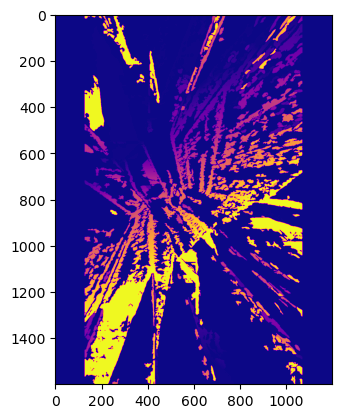

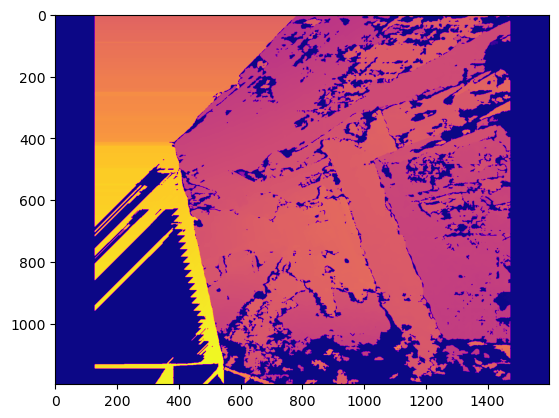

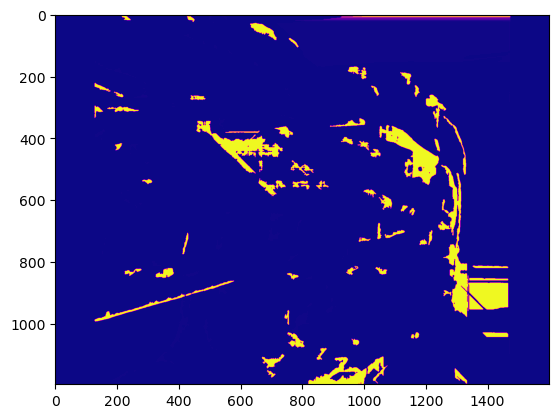

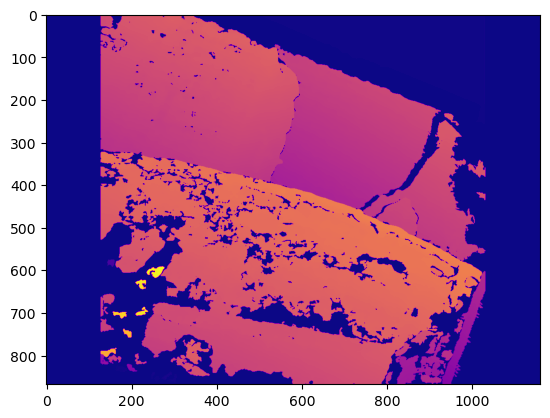

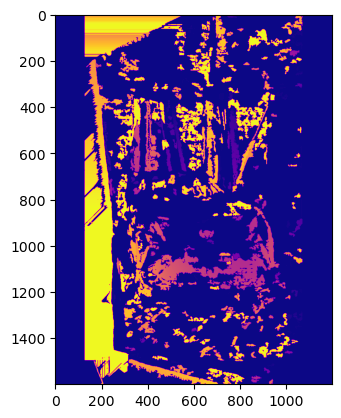

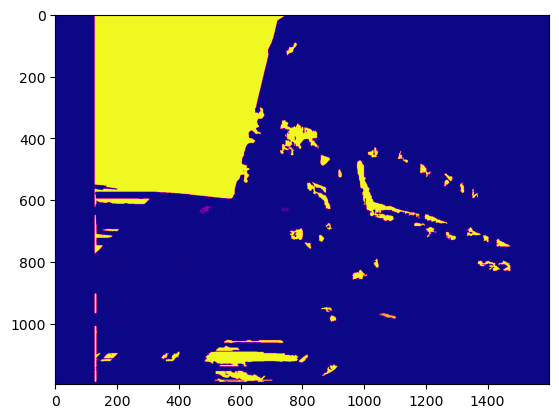

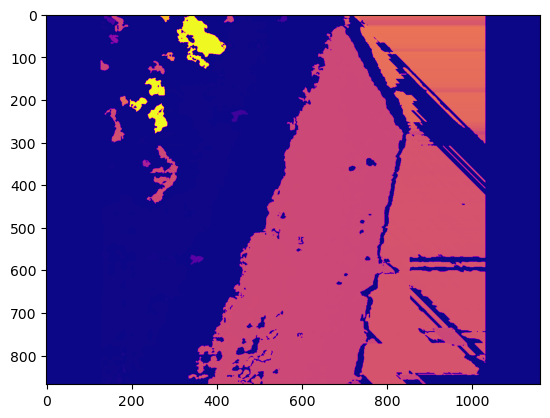

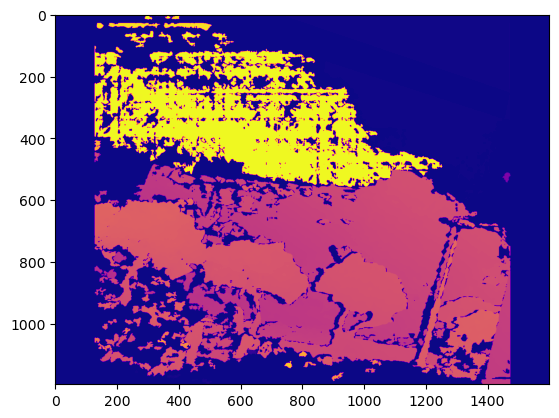

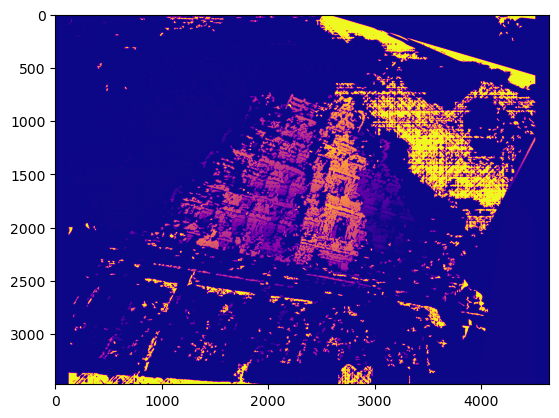

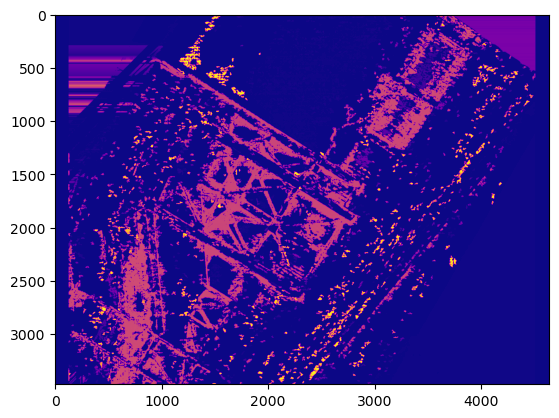

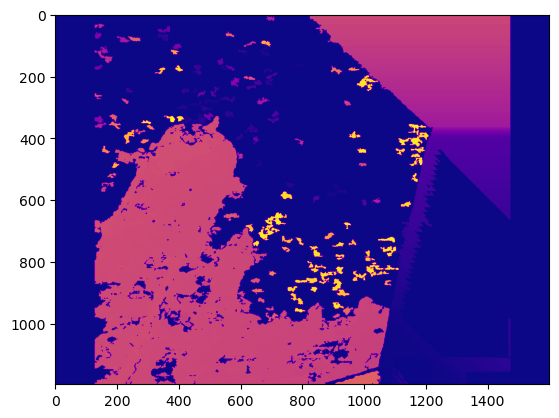

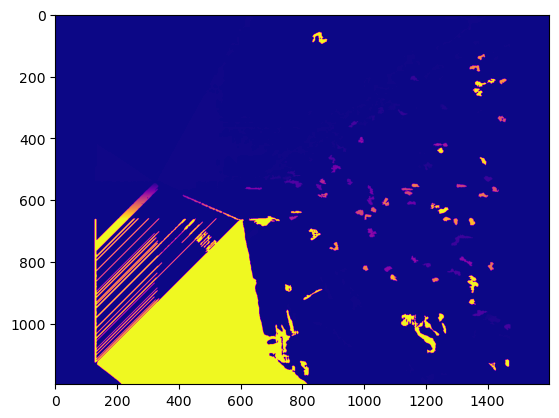

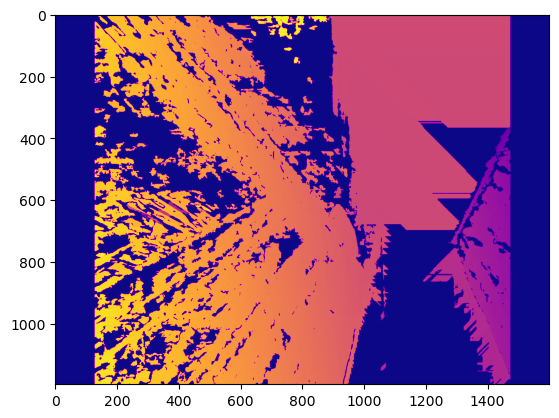

error: OpenCV(4.6.0) C:\b\abs_d8ltn27ay8\croot\opencv-suite_1676452046667\work\modules\calib3d\src\stereosgbm.cpp:2212: error: (-215:Assertion failed) left.size() == right.size() && left.type() == right.type() && left.depth() == CV_8U in function 'cv::StereoSGBMImpl::compute'


In [29]:
#declare path of folder where images are stored
path = 'ourdataset/'
type = ""
length = len(glob.glob(path+'*'))
if(path=='ourdataset/'):
    type = ".jpg"
elif(path=='Middleburydataset/'):
    type = ".png"
#obtaining the depth map for all images
for i in range(length//2):
    path1 = path+str(2*i+1)+type
    path2 = path+str(2*i+2)+type
    img1 = cv.imread(path1, cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(path2, cv.IMREAD_GRAYSCALE)
    illuminationrequired = False
    if(illuminationrequired):
        img1, img2 = increaseillumination(img1, img2, i)
    kp1, kp2, des1, des2 = siftkeypointsdetection(img1, img2)
    #visualizeKeypoints(img1, img2, kp1, kp2)
    typeofmatcher = 'bruteforce'
    matches, matchesMask, good, pts1, pts2 = swiftmatching(des1, des2, typeofmatcher, kp1, kp2)
    #visualizeMatches(img1, img2, kp1, kp2, good, matchesMask, matches)
    pts1, pts2, fundamental_matrix, inliers = findfundamentalmatrix(pts1, pts2)
    pts1, pts2 = selectinlier(pts1, pts2, inliers)
    #drawepilines(img1, img2, pts1, pts2, fundamental_matrix)
    img1_rectified, img2_rectified = stereorectification(img1, img2, pts1, pts2, fundamental_matrix)
    #plotrectifiedimages(img1_rectified, img2_rectified)
    disparity_SGBM = depthmap(img1_rectified, img2_rectified, i)
    plotdepthmap(disparity_SGBM, type,i)
    
    
    